### Artificial Intelligence 2024/2025
##  Assignment: Adversarial search strategies and Decision Trees


Trabalho realizado por Maria Inês Rocha e Matilde Morais. 

The goal of this assignment is to implement the Monte Carlo Tree Search (MCTS) algorithms and a
decision tree for each given dataset learned using the ID3 procedure.

Objetivos:
- Implementar IA para o jogo Connect Four usando MCTS
- Gerar dados com MCTS
- Treinar uma árvore de decisão com o algoritmo ID3 

In [1]:
from typing import List, Optional
import random
import math

# Board

- Esta classe representa o tabuleiro de jogo Connect Four, incluindo o estado atual e as jogadas possíveis

In [2]:
class Board:

    #Inicializa um novo estado de tabuleiro.
    def __init__(self, in_board: List[List[int]], lm: int):
        self.b = [row[:] for row in in_board]
        self.pieces_column = [0] * 7
        for i in range(6):
            for j in range(7):
                if self.b[i][j] in [1, 2]:
                    self.pieces_column[j] += 1
        self.lastMove = lm
        self.parent = None

    #Verifica se a coluna está cheia ou se o índice é inválido
    def verifyColumnFull(self, col: int) -> bool:
        return col < 0 or col > 6 or self.pieces_column[col] >= 6

    #Retorna uma cópia do estado atual do tabuleiro
    def getBoard(self) -> List[List[int]]:
        return [row[:] for row in self.b]

    #Retorna o estado anterior do tabuleiro
    def getParent(self):
        return self.parent

    #Retorna a lista com contagem de peças em cada coluna
    def getPiecesCol(self) -> List[int]:
        return self.pieces_column

    #Retorna o índice da coluna escolhida na última jogada
    def getLastMove(self) -> int:
        return self.lastMove

    #Define o estado pai para este nó
    def setParent(self, p):
        self.parent = p

    #Gera um novo estado do tabuleiro após o jogador inserir uma peça
    def makeMove(self, col: int, player: int):
        if self.verifyColumnFull(col):
            return None
        n = self.pieces_column[col]
        newboard = self.getBoard()
        newboard[5 - n][col] = player
        return Board(newboard, col)

    #Retorna as colunas onde ainda é possível jogar
    def getValidMoves(self) -> List[int]:
        moves = [i for i in range(7) if not self.verifyColumnFull(i)]
        random.shuffle(moves)
        return moves

    #Compara dois estados de tabuleiro
    def __eq__(self, other):
        return self.b == other.b

    #Gera uma representação do tabuleiro.
    def __str__(self) -> str:
        s = ""
        for i in range(6):
            s += "|"
            for j in range(7):
                if self.b[i][j] == 0:
                    s += "   "
                elif self.b[i][j] == 1:
                    s += " X "
                elif self.b[i][j] == 2:
                    s += " O "
                if j != 6:
                    s += "|"
            s += "|\n"
        s += "_____________________________\n"
        s += "  1   2   3   4   5   6   7 \n"
        return s

In [3]:

# Verificação inicial
initial_board = [[0]*7 for _ in range(6)]
b = Board(initial_board, -1)
print(b)

|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 



###  Monte Carlo Tree Search (MCTS)

O MCTS é um algoritmo baseado em simulações aleatórias para avaliar o melhor movimento a cada estado do jogo. Utiliza quatro passos principais:

1. **Seleção**: Percorre a árvore até um nó não explorado com base na função UCT (Upper Confidence Bound for Trees);
2. **Expansão**: Gera novos nós filhos a partir do nó selecionado;
3. **Simulação**: Joga até ao fim de forma aleatória;
4. **Retropropagação**: Atualiza as estatísticas de vitórias e simulações na árvore.

# Heuristics 
- Centraliza toda a lógica de avaliação e término do jogo Connect Four.

In [4]:
class Heuristics:

    #Determina se o jogo chegou ao fim
    @staticmethod
    def isFinished(b: Board) -> bool:
        return Heuristics.win(b) != 0 or all(b.verifyColumnFull(i) for i in range(7))

    #Verifica se há vencedor
    @staticmethod
    def win(b: Board) -> int:
        bb = b.getBoard()
        # Horizontal
        for i in range(6):
            for j in range(4):
                if bb[i][j] != 0 and all(bb[i][j + k] == bb[i][j] for k in range(4)):
                    return 1 if bb[i][j] == 1 else -1
        # Vertical
        for i in range(3, 6):
            for j in range(7):
                if bb[i][j] != 0 and all(bb[i - k][j] == bb[i][j] for k in range(4)):
                    return 1 if bb[i][j] == 1 else -1
        # Diagonal
        for i in range(3, 6):
            for j in range(4):
                if bb[i][j] != 0 and all(bb[i - k][j + k] == bb[i][j] for k in range(4)):
                    return 1 if bb[i][j] == 1 else -1
                if bb[i][j + 3] != 0 and all(bb[i - k][j + 3 - k] == bb[i][j + 3] for k in range(4)):
                    return 1 if bb[i][j + 3] == 1 else -1
        return 0

    @staticmethod
    def getScore(b: Board) -> int:
        win = Heuristics.win(b)
        if win == 1:
            return 10
        elif win == -1:
            return -10
        return 0  # Simplificado para foco no jogo em si


# MCTSConstants
- Constantes usadas pelo algoritmo de Monte Carlo Tree Search (MCTS).

In [5]:
class MCTSConstants:
    MCTS_ITERATIONS = 1000 #Nº de simulações
    EXPLORATION = math.sqrt(2)# Fator de exploração (c) no termo UCB
    INF = float('inf')#Valor de infinito positivo, para inicializar limites

# MCTSState
- Representa um nó na árvore de pesquisa Monte Carlo (MCTS).

In [7]:
class MCTSState:
    def __init__(self, board: Board, player: int, parent: Optional['MCTSState']):
        self.cur_b = board
        self.player = player
        self.parent = parent
        self.children: List[MCTSState] = []
        self.u = 0.0
        self.n = 0.0

    #Calcula o valor UCT para este nó
    def getUCT(self) -> float:
        if self.n == 0:
            return MCTSConstants.INF
        return (self.u / self.n) + MCTSConstants.EXPLORATION * math.sqrt(math.log(self.parent.n) / self.n)

# MCTS Algorithm
- Implementa o algoritmo Monte Carlo Tree Search (MCTS) para Connect Four.

In [8]:
class MCTS:

    #Inicializa o MCTS com um nó raiz baseado no tabuleiro fornecido
    def __init__(self, board: Board):
        self.root = MCTSState(board, 2, None)

    def select(self) -> MCTSState:
        cur = self.root
        while cur.children:
            cur.children.sort(key=lambda c: -c.getUCT())
            max_uct = cur.children[0].getUCT()
            best = [c for c in cur.children if c.getUCT() == max_uct]
            cur = random.choice(best)
            if cur.n == 0:
                return cur
        return cur

    def expand(self, leaf: MCTSState) -> MCTSState:
        if Heuristics.isFinished(leaf.cur_b):
            return leaf
        for move in leaf.cur_b.getValidMoves():
            new_b = leaf.cur_b.makeMove(move, leaf.player)
            new_b.setParent(leaf.cur_b)
            child = MCTSState(new_b, 3 - leaf.player, leaf)
            leaf.children.append(child)
        return random.choice(leaf.children)

    def rollout(self, node: MCTSState) -> int:
        board = node.cur_b
        player = node.player
        while not Heuristics.isFinished(board):
            move = random.choice(board.getValidMoves())
            board = board.makeMove(move, player)
            player = 3 - player
        score = Heuristics.getScore(board)
        return 0 if score == 0 else (1 if score == 10 else 2)

    def backpropagate(self, node: MCTSState, result: int):
        reward = 1 if result != node.player else 0
        while node:
            node.n += 1
            node.u += reward
            node = node.parent
            reward = 1 - reward if result != 0 else 0

    def playMCTS(self) -> int:
        for _ in range(MCTSConstants.MCTS_ITERATIONS):
            leaf = self.select()
            child = self.expand(leaf)
            outcome = self.rollout(child)
            self.backpropagate(child, outcome)
        best_child = max(self.root.children, key=lambda c: c.n, default=None)
        return best_child.cur_b.getLastMove() if best_child else -1

# Funções para simular os modos:
    1. MCTS vs MCTS
    2. Humano vs MCTS 
    3. Humano vs Humano 

In [ ]:
#Gera e executa o loop principal de um jogo Connect Four.
def play_game(mode="human_vs_human"):
    initial_board = [[0]*7 for _ in range(6)]
    board = Board(initial_board, -1)
    player = 1  # 1 = X, 2 = O

    while not Heuristics.isFinished(board): ## Continua jogar enquanto não houver vitória ou empate
        print(board)
        if mode == "human_vs_human":
            print(f"Player {'X' if player == 1 else 'O'}'s turn.")
            move = int(input("Choose a column (1-7): ")) - 1
            while board.makeMove(move, player) is None:
                print("Invalid move. Try again.")
                move = int(input("Choose a column (1-7): ")) - 1
            board = board.makeMove(move, player)

        elif mode == "human_vs_mcts":
            if player == 1:
                print("Your turn (Player X).")
                move = int(input("Choose a column (1-7): ")) - 1
                while board.makeMove(move, player) is None:
                    print("Invalid move. Try again.")
                    move = int(input("Choose a column (1-7): ")) - 1
                board = board.makeMove(move, player)
            else:
                print("MCTS (Player O) is thinking...")
                ai = MCTS(board)
                move = ai.playMCTS()
                board = board.makeMove(move, player)

        elif mode == "mcts_vs_mcts":
            print(f"MCTS Player {'X' if player == 1 else 'O'} is thinking...")
            ai = MCTS(board)
            move = ai.playMCTS()
            board = board.makeMove(move, player)

        player = 3 - player  # Alternar entre 1 e 2

    print(board)
    score = Heuristics.getScore(board)
    if score == 10:
        print("Player X won!")
    elif score == -10:
        print("Player O won!")
    else:
        print("It's a draw!")

In [10]:
play_game("mcts_vs_mcts")

|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

MCTS Player X is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

MCTS Player O is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   | O |   | X |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

MCTS Player X is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   | O |   | X |   | X |   |
_____________

In [45]:
play_game("human_vs_mcts")

|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

Your turn (Player X).
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

MCTS (Player O) is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | O |   |   |   |
|   |   |   | X |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

Your turn (Player X).
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | O |   |   |   |
|   |   | X | X |   |   |   |
_________________________

In [12]:
play_game("human_vs_human")

|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

Player X's turn.
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

Player O's turn.
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X | O |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

Player X's turn.
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X |   |   |   |   |   |   |
| X | O |   |   |   |   |   |
_____________________________
  1   2   3   4   5

## Gerar cvs com dados do jogo

In [27]:
#[estado como lista de 42 inteiros] + [coluna escolhida pelo MCTS]
def flatten_board(board):
    #Converte o tabuleiro 6x7 numa lista linear de 42 inteiros
    return [cell for row in board.getBoard() for cell in row]

## Função generate_dataset
- Gera um dataset com base nas simulações do MCTS. Cada linha representa o estado do tabuleiro e a jogada escolhida

In [ ]:
import csv

def generate_dataset(num_games: int, file_path: str):
    """Gera um dataset de jogadas do MCTS: (índice, estado, jogada)."""
    with open(file_path, "w", newline="") as f:
        writer = csv.writer(f)
        header = ["index"] + [f"col{i}" for i in range(42)] + ["move"]
        writer.writerow(header)

        index = 0
        for game in range(num_games):
            board = Board([[0]*7 for _ in range(6)], -1)
            player = 1

            while not Heuristics.isFinished(board):
                if player == 2:
                    mcts = MCTS(board)
                    move = mcts.playMCTS()
                    if move == -1:
                        break
                    flat = flatten_board(board)
                    writer.writerow([index] + flat + [move])
                    index += 1
                    board = board.makeMove(move, player)
                else:
                    valid = board.getValidMoves()
                    if not valid:
                        break
                    move = random.choice(valid)
                    board = board.makeMove(move, player)
                player = 3 - player
            print(f"Jogo {game + 1}/{num_games} concluído.")


generate_dataset(500, r"C:\Users\Matilde\2ºano\2ºsem\inteligencia artificial\trabalho\connect_dataset.csv")


Jogo 1/500 concluído.
Jogo 2/500 concluído.
Jogo 3/500 concluído.
Jogo 4/500 concluído.
Jogo 5/500 concluído.
Jogo 6/500 concluído.
Jogo 7/500 concluído.
Jogo 8/500 concluído.
Jogo 9/500 concluído.
Jogo 10/500 concluído.
Jogo 11/500 concluído.
Jogo 12/500 concluído.
Jogo 13/500 concluído.
Jogo 14/500 concluído.
Jogo 15/500 concluído.
Jogo 16/500 concluído.
Jogo 17/500 concluído.
Jogo 18/500 concluído.
Jogo 19/500 concluído.
Jogo 20/500 concluído.
Jogo 21/500 concluído.
Jogo 22/500 concluído.
Jogo 23/500 concluído.
Jogo 24/500 concluído.
Jogo 25/500 concluído.
Jogo 26/500 concluído.
Jogo 27/500 concluído.
Jogo 28/500 concluído.
Jogo 29/500 concluído.
Jogo 30/500 concluído.
Jogo 31/500 concluído.
Jogo 32/500 concluído.
Jogo 33/500 concluído.
Jogo 34/500 concluído.
Jogo 35/500 concluído.
Jogo 36/500 concluído.
Jogo 37/500 concluído.
Jogo 38/500 concluído.
Jogo 39/500 concluído.
Jogo 40/500 concluído.
Jogo 41/500 concluído.
Jogo 42/500 concluído.
Jogo 43/500 concluído.
Jogo 44/500 concluíd

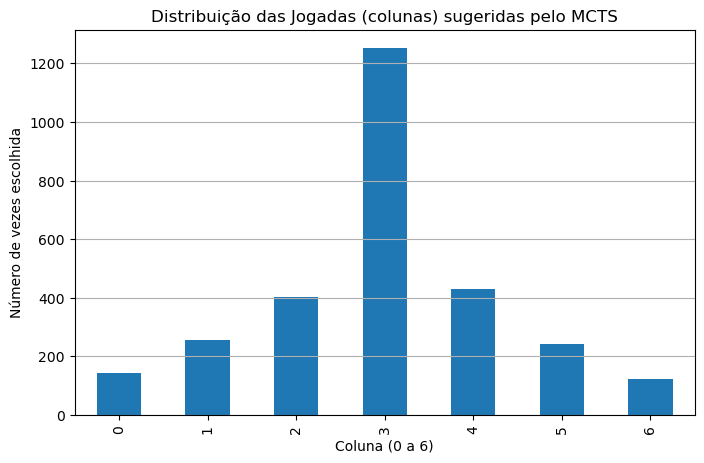

In [13]:
#conta quantas vezes cada coluna foi escolhida para mostrar a distribuição

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("connect_dataset.csv")
plt.figure(figsize=(8, 5))
df['move'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribuição das Jogadas (colunas) sugeridas pelo MCTS")
plt.xlabel("Coluna (0 a 6)")
plt.ylabel("Número de vezes escolhida")
plt.grid(axis='y')
plt.show()

In [14]:
from collections import Counter
def load_dataset(path):
    df = pd.read_csv(path, header=None)
    features = df.columns[:-1]
    label_col = df.columns[-1]
    return df, features, label_col
df, features, label_col = load_dataset("connect_dataset.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,index,col0,col1,col2,col3,col4,col5,col6,col7,col8,...,col33,col34,col35,col36,col37,col38,col39,col40,col41,move
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,4
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,2,0,1,1
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,1,2,0,1,4


In [15]:
df.shape

(2848, 44)

### ID3 - Árvore de Decisão

O algoritmo ID3 constrói uma árvore de decisão com base na entropia e ganho de informação:

1. Escolhe o atributo que mais reduz a incerteza (maior ganho de informação);
2. Cria um nó para esse atributo e ramos para cada valor;
3. Repete recursivamente até que os dados estejam bem classificados ou acabem os atributos.

Foi usada para classificação:
- O **dataset Iris** (com discretização de valores numéricos)
- Um **dataset de Connect Four**, gerado com jogadas do MCTS

### A seguinte implementação inclui:

- **Series e DataFrame** para gerir dados internamente sem depender do pandas
- **DTNode** para representar os nós da árvore de decisão
- **DecisionTree**, com os seguintes componentes:
  - **Cálculo de Entropia** para medir a incerteza de atributos
  - **Ganho de Informação** para selecionar os melhores atributos a cada divisão
  - **Ramificação Recursiva** para construção da árvore
  - **Previsão com fallback inteligente** (casos não vistos durante o treino)
  - **Limite de profundidade (max_depth)** para evitar overfitting


In [ ]:
import collections
import math

#armazena uma coluna de dados com métodos para acessar valores
class Series:
    def __init__(self, name):
        self.name = name
        self.data = []

    def add(self, value):
        self.data.append(value)

    def getDataList(self):
        return self.data

    def getUniqueValues(self):
        return set(self.data)

    def getName(self):
        return self.name

    def getValue(self, index):
        return self.data[index]

#reúne várias Series, permite obter dimensões, colunas e filtrar linhas por valor de atributo.
class DataFrame:
    def __init__(self, series_list):
        self.series = series_list

    def getNumberColumns(self):
        return len(self.series)

    def getNumberRows(self):
        return len(self.series[0].getDataList())

    def getColumn(self, index):
        return self.series[index]

    def filterBySpecificAttributeValue(self, col_index, value):
        indices = [i for i, v in enumerate(self.series[col_index].getDataList()) if v == value]
        new_series = []
        for s in self.series:
            filtered_data = [s.getDataList()[i] for i in indices]
            new_s = Series(s.getName())
            new_s.data = filtered_data
            new_series.append(new_s)
        return DataFrame(new_series)

#nó da árvore, que pode ser interno (com attribute e children) ou folha (com classification e count).
class DTNode:
    def __init__(self, attribute_or_class, count=None):
        self.attribute = attribute_or_class
        self.children = {}
        self.count = count
        self.classification = None if count is None else attribute_or_class

    def isLeaf(self):
        return self.classification is not None

    def getNodeAttribute(self):
        return self.attribute

    def getChildren(self):
        return self.children

    def addChild(self, value, child):
        self.children[value] = child

    def getChild(self, value):
        return self.children.get(value)

    def getClassification(self):
        return self.classification

    def getCount(self):
        return self.count

class DecisionTree: #implementa as etapas de ID3
    def __init__(self):
        self.root = None
        self.training = None
        self.num_nodes = 0

    def getMostFrequentValue(self, s):
        freq = collections.Counter(s.getDataList())
        max_freq = max(freq.values())
        most_frequent = [k for k, v in freq.items() if v == max_freq]
        return most_frequent[0]

    def pluralityValue(self, data):
        target = data.getColumn(-1)
        classification = self.getMostFrequentValue(target)
        return DTNode(classification, target.getDataList().count(classification))

    def entropy(self, series):
        freq = collections.Counter(series.getDataList())
        total = len(series.getDataList())
        return -sum((count / total) * math.log2(count / total) for count in freq.values())

    def getGain(self, target, attribute):
        total_entropy = self.entropy(target)
        values = attribute.getUniqueValues()
        total = len(target.getDataList())
        remainder = 0
        for v in values:
            indices = [i for i, x in enumerate(attribute.getDataList()) if x == v]
            subset = [target.getDataList()[i] for i in indices]
            if len(subset) == 0:
                continue
            freq = collections.Counter(subset)
            subset_total = len(subset)
            ent = -sum((c / subset_total) * math.log2(c / subset_total) for c in freq.values())
            remainder += (subset_total / total) * ent
        return total_entropy - remainder
    
    def getAttributeHighestGain(self, examples, attributes_id):
        target = examples.getColumn(-1)
        gains = [(i, self.getGain(target, examples.getColumn(i))) for i in attributes_id]
        return max(gains, key=lambda x: x[1])[0]

    #constrói recursivamente a árvore escolhendo o atributo de maior ganho
    def learnDecisionTree(self, examples, attributes_id, parent_examples, depth=0, max_depth=50):
        if max_depth is not None and depth >= max_depth:
            return self.pluralityValue(examples)
        
        self.num_nodes += 1
        if examples.getNumberRows() == 0:
            return self.pluralityValue(parent_examples)

        target = examples.getColumn(-1)
        if len(target.getUniqueValues()) == 1:
            return self.pluralityValue(examples)

        if not attributes_id:
            return self.pluralityValue(examples)

        best_attr = self.getAttributeHighestGain(examples, attributes_id)
        node = DTNode(examples.getColumn(best_attr).getName())
        values = examples.getColumn(best_attr).getUniqueValues()

        for v in values:
            subset = examples.filterBySpecificAttributeValue(best_attr, v)
            new_attrs = [i for i in attributes_id if i != best_attr]
            child = self.learnDecisionTree(subset, new_attrs, examples, depth+1, max_depth)
            node.addChild(v, child)

        return node

    #treina a árvore
    def fit(self, data, max_depth=50):
        self.training = data
        attributes_id = list(range(data.getNumberColumns() - 1))
        self.root = self.learnDecisionTree(data, attributes_id, None, depth=0, max_depth=max_depth)


    #percorre a árvore para cada instância de um novo DataFrame e retorna uma série com as classes previstas
    def predict(self, data_to_predict):
        col_name_to_index = {data_to_predict.getColumn(i).getName(): i for i in range(data_to_predict.getNumberColumns())}
        prediction = Series("Predicted")

        for row in range(data_to_predict.getNumberRows()):
            cur = self.root
            cur_df = self.training

            while not cur.isLeaf():
                col_index = col_name_to_index.get(cur.getNodeAttribute())
                if col_index is None:
                    break
                val = data_to_predict.getColumn(col_index).getValue(row)
                cur = cur.getChild(val)
                if cur is None:
                    prediction.add(self.getMostFrequentValue(cur_df.getColumn(-1)))
                    break
                cur_df = cur_df.filterBySpecificAttributeValue(col_index, val)

            if cur is not None and cur.isLeaf():
                prediction.add(cur.getClassification())

        return prediction

In [25]:
import pandas as pd

# 1. Le e discretiza 
iris_df = pd.read_csv("iris.csv")
labels = ["low", "medium", "high"]
for col in iris_df.columns[:-1]:
    iris_df[col] = pd.cut(iris_df[col], bins=3, labels=labels)

# 2. Separe 70% para treino por amostragem aleatória
train_df = iris_df.sample(frac=0.7, random_state=42)
# 3. O restante vira para teste
test_df = iris_df.drop(train_df.index)

# 4. Converte para o DataFrame customizado e treina/testa
def to_custom_df(df):
    series_list = []
    for col in df.columns:
        s = Series(col)
        for val in df[col]:
            s.add(str(val))
        series_list.append(s)
    return DataFrame(series_list)

train_data = to_custom_df(train_df)
test_data  = to_custom_df(test_df)

# 5. Treina 
tree = DecisionTree()
tree.fit(train_data, max_depth=3)

# 6. Avalia
predicted = tree.predict(test_data)
actual    = test_data.getColumn(-1).getDataList()
correct   = sum(1 for a, p in zip(actual, predicted.getDataList()) if a == p)
accuracy  = correct / len(actual)

print(f"Acurácia no teste: {accuracy:.2f}")


Acurácia no teste: 1.00


***Nota:*** Para usar o algoritmo ID3, que só lida com atributos nominais, transformamos as variáveis contínuas do conjunto Iris em categoricas. Escolhemos três bins de largura fixa rotulados como “low” (baixo), “medium” (médio) e “high” (alto).

In [28]:
import pandas as pd

df = pd.read_csv("connect_dataset.csv")

# Ignora a coluna "index" ao construir as Series
series_list = []
for col in df.columns:
    if col != "index":  # Ignorar o índice
        s = Series(col)
        for val in df[col]:
            s.add(str(val))  # Converte para string para compatibilidade com a árvore
        series_list.append(s)

# Construir DataFrame custom
df_custom = DataFrame(series_list)

# Treina a árvore
tree = DecisionTree()
tree.fit(df_custom)

# 4. Prever a jogada para um novo estado
# Exemplo: novo estado codificado como lista de 42 strings
# Pode ser algo como ['0', '0', '1', '2', ..., '0'] com '0' = vazio, '1' = player1, '2' = player2

# Exemplo de previsão de um estado
input_board = flatten_board(b)  # -> lista de 42 inteiros
series_input = []

# Repetir para col0 a col41
for i in range(42):
    s = Series(f"col{i}")
    s.add(str(input_board[i]))  # sempre string
    series_input.append(s)

# Última coluna simulada (valor não importa, não será usado na previsão)
s_move = Series("move")
s_move.add("0")
series_input.append(s_move)

# Criar DataFrame para prever
new_df = DataFrame(series_input)

# Prever
prediction = tree.predict(new_df)
print("Jogada sugerida pela árvore:", prediction.getValue(0))



Jogada sugerida pela árvore: 3


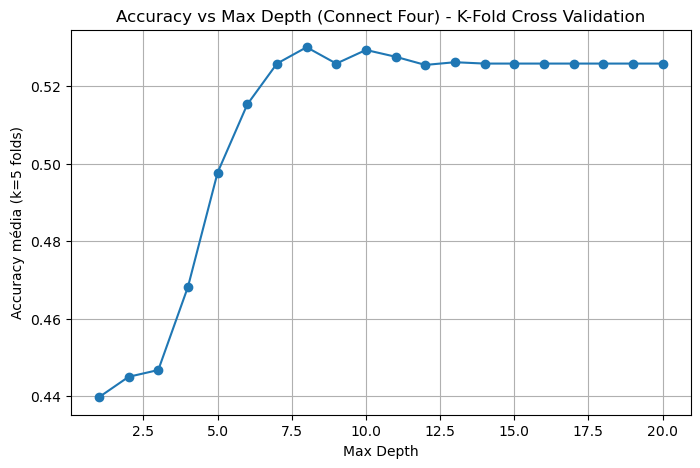

In [ ]:
import matplotlib.pyplot as plt
import random

# Criar DataFrame customizado (ignora "index")
series_list = []
for col in df.columns:
    if col != "index":
        s = Series(col)
        for val in df[col]:
            s.add(str(val))
        series_list.append(s)

df_custom = DataFrame(series_list)

# Função para fazer slice(seleciona apenas um subconjunto dos seus elementos)
def slice_dataframe(df, indices):
    sliced_series = []
    for col in df.series:
        s = Series(col.getName())
        for i in indices:
            s.add(col.getValue(i))
        sliced_series.append(s)
    return DataFrame(sliced_series)

# Configura k-fold
k = 5  # número de folds
indices = list(range(df_custom.getNumberRows()))
random.shuffle(indices)  # baralhar

fold_size = len(indices) // k

depths = range(1, 21)  # testar profundidade de 1 a 20
accuracies = []

for depth in depths:
    fold_accuracies = []
    
    for fold in range(k):
        # Separar fold de teste
        start = fold * fold_size
        end = (fold + 1) * fold_size if fold != k - 1 else len(indices)
        test_idx = indices[start:end]
        train_idx = indices[:start] + indices[end:]

        # Criar dados
        train_data = slice_dataframe(df_custom, train_idx)
        test_data = slice_dataframe(df_custom, test_idx)

        # Treinar e avaliar
        tree = DecisionTree()
        tree.fit(train_data, max_depth=depth)
        predicted = tree.predict(test_data)
        
        actual = test_data.getColumn(-1).getDataList()
        predicted = predicted.getDataList()
        
        correct = sum(1 for a, p in zip(actual, predicted) if a == p)
        acc = correct / len(actual)
        fold_accuracies.append(acc)
    
    # Accuracy média dos k folds
    mean_accuracy = sum(fold_accuracies) / k
    accuracies.append(mean_accuracy)

# Desenhar o gráfico
plt.figure(figsize=(8,5))
plt.plot(depths, accuracies, marker='o')
plt.title("Accuracy vs Max Depth (Connect Four) - K-Fold Cross Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy média (k=5 folds)")
plt.grid(True)
plt.show()

**Interpretaçao:** Com a validação cruzada com 5 folds, variamos a profundidade máxima da árvore de decisão para avaliar o impacto na precisão do modelo. Observamos que a acurácia tende a aumentar até certo ponto e depois estabiliza ou decresce, indicando overfitting. Este gráfico ajudou a escolher uma profundidade ideal de 9 para balancear generalização e complexidade

In [34]:
tree = DecisionTree()
tree.fit(train_data, max_depth=9)
predicted = tree.predict(test_data)

In [35]:
#avaliação do modelo no conjunto de teste
actual = test_data.getColumn(-1).getDataList()
predicted = predicted.getDataList()

correct = sum(1 for a, p in zip(actual, predicted) if a == p)
accuracy = correct / len(actual)
print(f"Accuracy no conjunto de teste: {accuracy:.2f}")

Accuracy no conjunto de teste: 0.53


O ID3 funciona muito bem em datasets limpos, balanceados e com separação clara entre classes (como o Iris).
No entanto, o seu desempenho degrada significativamente quando enfrenta ruído, desbalanceamento ou padrões complexos, como acontece no dataset gerado pelo mcts.

In [ ]:
#Adaptador que utiliza o modelo DecisionTree para sugerir jogadas 
class ID3Player:
    def __init__(self, decision_tree):
        self.model = decision_tree

    #Preve a coluna em que a próxima peça deve ser jogada
    def predict(self, flat_board):
        series_list = []
        for i in range(42):
            s = Series(f"col{i}")
            s.add(str(flat_board[i]))
            series_list.append(s)

        target = Series("move")
        target.add("0")  # Dummy
        series_list.append(target)

        df = DataFrame(series_list)
        prediction = self.model.predict(df)

        # Verifica se prediction está vazio
        pred_list = prediction.getDataList()
        if len(pred_list) == 0:
            # fallback
            #return 0  
            valid = [i for i in range(7) if flat_board.verifyColumnFull(i) is False]
            return random.choice(valid) 
        return int(pred_list[0])

In [ ]:
#Faz um jogo d entre duas instâncias do mesmo modelo ID3
def play_id3_vs_id3(id3_model):
    initial_board = [[0]*7 for _ in range(6)]
    board = Board(initial_board, -1)
    player = 1

    while not Heuristics.isFinished(board):
        print(board)
        print(f"ID3 Player {'X' if player == 1 else 'O'} is thinking...")
        
        features = sum(board.getBoard(), [])  # flatten board
        move = id3_model.predict(features)  # Usa o modelo ID3
        if board.makeMove(move, player) is None:
            print("ID3 chose an invalid move. Choosing randomly.")
            move = random.choice(board.getValidMoves())

        board = board.makeMove(move, player)
        player = 3 - player

    print(board)
    result = Heuristics.getScore(board)
    if result == 10:
        print("Player X (ID3) won!")
    elif result == -10:
        print("Player O (ID3) won!")
    else:
        print("It's a draw!")

In [56]:
id3_player = ID3Player(tree)
play_id3_vs_id3(id3_player)

|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

ID3 Player X is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

ID3 Player O is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X | O |   |   |
_____________________________
  1   2   3   4   5   6   7 

ID3 Player X is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
|   |   |   | X | O |   |   |
________________

In [ ]:
def play_human_vs_id3(id3_model):
    initial_board = [[0]*7 for _ in range(6)]
    board = Board(initial_board, -1)
    player = 1

    while not Heuristics.isFinished(board):
        print(board)
        if player == 1:
            print("Your turn (Player X).")
            print("Choose a column (1-7):\n", end='', flush=True)
            move = int(input()) - 1
            while board.makeMove(move, player) is None:
                print("Invalid move. Try again.")
                print("Choose a column (1-7):\n", end='', flush=True)
                move = int(input()) - 1
        else:
            print("ID3 (Player O) is thinking...")
            features = sum(board.getBoard(), [])  # flatten board
            move = id3_model.predict(features)
            if board.makeMove(move, player) is None:
                print("ID3 chose an invalid move. Choosing randomly.")
                move = random.choice(board.getValidMoves())

        board = board.makeMove(move, player)
        player = 3 - player

    print(board)
    result = Heuristics.getScore(board)
    if result == 10:
        print("Player X (Human) won!")
    elif result == -10:
        print("Player O (ID3) won!")
    else:
        print("It's a draw!")

In [ ]:
play_human_vs_id3(id3_player)

|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

Your turn (Player X).
Choose a column (1-7):
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

ID3 (Player O) is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X | O |   |   |
_____________________________
  1   2   3   4   5   6   7 

Your turn (Player X).
Choose a column (1-7):
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   | X |   |   |
|   |   | 

In [61]:
#faz jogo entre ID3 e MCTS
def play_id3_vs_mcts(id3_model, mcts_iterations=1000, display=True):
    initial_board = [[0]*7 for _ in range(6)]
    board = Board(initial_board, -1)
    player = 1  # 1 = X (ID3), 2 = O (MCTS)

    while not Heuristics.isFinished(board):
        if display:
            print(board)
            print(f"{'ID3' if player == 1 else 'MCTS'} is thinking...")

        if player == 1:
            # ID3 joga
            features = sum(board.getBoard(), [])  # flatten board
            move = id3_model.predict(features) #preve coluna
            if move not in board.getValidMoves(): #fallback se for invalida
                if display:
                    print("ID3 chose an invalid move. Choosing randomly.")
                move = random.choice(board.getValidMoves())
        else:
            # MCTS joga
            mcts = MCTS(board)
            MCTSConstants.MCTS_ITERATIONS = mcts_iterations  # ajustar dinamicamente
            move = mcts.playMCTS()
            if move not in board.getValidMoves():
                if display:
                    print("MCTS chose an invalid move. Choosing randomly.")
                move = random.choice(board.getValidMoves())

        board = board.makeMove(move, player) #aplica a jogada
        player = 3 - player  # alterna entre 1 e 2

    if display:
        print(board)
    result = Heuristics.getScore(board)
    if display:
        if result == 10:
            print("Player X (ID3) won!")
        elif result == -10:
            print("Player O (MCTS) won!")
        else:
            print("It's a draw!")
    return result


In [62]:
id3_player = ID3Player(tree)
play_id3_vs_mcts(id3_player, mcts_iterations=1000)

|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

ID3 is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
_____________________________
  1   2   3   4   5   6   7 

MCTS is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X | O |   |   |
_____________________________
  1   2   3   4   5   6   7 

ID3 is thinking...
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | X |   |   |   |
|   |   |   | X | O |   |   |
_____________________________
  1   2   3 

-10

In [65]:
#Avaliação de quem ganha mais jogos entre ID3 vs. MCTS.
def evaluate_id3_vs_mcts(id3_model, num_games=50):
    results = {"ID3": 0, "MCTS": 0, "Draw": 0}
    for i in range(num_games):
        result = play_id3_vs_mcts(id3_model, display=False)
        if result == 10:
            results["ID3"] += 1
        elif result == -10:
            results["MCTS"] += 1
        else:
            results["Draw"] += 1
    return results

In [66]:
stats = evaluate_id3_vs_mcts(id3_player, num_games=20)
print(stats)

{'ID3': 0, 'MCTS': 20, 'Draw': 0}


## Conclusão e Avaliação Final

### Visão Geral
Neste trabalho, desenvolvemos uma solução para o jogo **Connect Four**, utilizando técnicas como **Monte Carlo Tree Search (MCTS)** e **Árvore de Decisão com ID3**. O objetivo foi aplicar estratégias de pesquisa adversária e aprendizagem supervisionada num ambiente competitivo.



### Comparação entre MCTS e ID3

| Critério                | MCTS                           | ID3                              |
|-------------------------|--------------------------------|-----------------------------------|
| Tipo de abordagem       | Busca adversária (simulações)  | Aprendizagem supervisionada       |
| Tempo de decisão        | Mais lento (simulações aleatórias) | Muito rápido (poda pela árvore) |
| Precisão estratégica    | Elevada, especialmente em endgame | Limitada pela qualidade dos dados |
| Dependência de dados    | Nenhuma                         | Total (precisa de dataset)       |
| Explicabilidade         | Baixa            | Alta   |




### Resultados Obtidos
- O MCTS demonstrou forte desempenho com uma excelente performance.
- O ID3, treinado com dados do MCTS, conseguiu replicar jogadas medianas com um custo computacional muito menor.



### Conclusão
Com este trabalho, conseguimos cumprir todos os requisitos propostos, unindo teoria e prática de IA de forma aplicada e concreta.
